## Data loading. Efficient operations via sparse matrices

In [1]:
import pickle
import os

current_min_edges = 3
curr_vertex_degree_cutoff = 25
current_delta = 5

data_source="../SemanticGraph_delta_"+str(current_delta)+"_cutoff_"+str(curr_vertex_degree_cutoff)+"_minedge_"+str(current_min_edges)+".pkl"

if os.path.isfile(data_source):
    with open(data_source, "rb") as pkl_file:
        full_dynamic_graph_sparse, unconnected_vertex_pairs, unconnected_vertex_pairs_solution, year_start, years_delta, vertex_degree_cutoff, min_edges = pickle.load(pkl_file)
        
# :param full_dynamic_graph_sparse: Full graph, numpy array dim(n,3) [vertex v1, vertex v2, time stamp t1] 
# representing edges, up to t<=t1. The edge is formed between vertex v1 and v2 at time t
# (measured in days after 1.1.1990)

# :param unconnected_vertex_pairs, numpy array of vertex pairs [v1,v2] with no edge at t1 and deg(v1/2)>10.
# Question is whether these vertex pairs will have an edge at t2.

# :param year_start - Integer, year for t1. Edges with
# t1=(date(year_start,12,31)-date(1990,1,1)).days are included in full_dynamic_graph_sparse

# :param years_delta, Integer, number of years to predict, t2=(date(year_start+years_delta,12,31)-date(1990,1,1)).days

# :param vertex_degree_cutoff, Integer, number of minimal vertex degree for prediction

# :param min_edges, Integer, Predict edges which grew from zero to min_edges

In [2]:
full_dynamic_graph_sparse

array([[32126, 32203,  1460],
       [32126, 32378,  1460],
       [32126, 32546,  1460],
       ...,
       [52265, 54468,  9477],
       [52265, 58027,  9477],
       [54468, 58027,  9477]], dtype=int32)

In [3]:
from utils import NUM_OF_VERTICES
import numpy as np
import scipy.sparse as sp

# The concatenation is used to produce a symmetric adjacency matrix
data_rows = np.concatenate([full_dynamic_graph_sparse[:, 0], full_dynamic_graph_sparse[:, 1]])
data_cols = np.concatenate([full_dynamic_graph_sparse[:, 1], full_dynamic_graph_sparse[:, 0]])
data_ones = np.ones(len(data_rows), np.uint32)
print("Rows and columns concatenated")
# efficient row slicing here
adjM_csr = sp.csr_matrix((data_ones, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))
# efficient column slicing here
adjM_csc = sp.csc_matrix((data_ones, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))
print("Adjacency matrices completed")
# if multiple edges between the same nodes are present, they are converted to a single one with weight = #(edges)

Rows and columns concatenated
Adjacency matrices completed


In [4]:
# degree of 3rd node
adjM_csr[2,:].sum()

246

In [5]:
# degree vector (datatype is np.matrix)
adjM_csr.sum(1)

matrix([[ 6856],
        [12481],
        [  246],
        ...,
        [    0],
        [    0],
        [    0]], dtype=uint64)

In [6]:
# degree vector (datatype is np.ndarray)
degree_vector = adjM_csr.sum(1).A1
degree_vector

array([ 6856, 12481,   246, ...,     0,     0,     0], dtype=uint64)

In [7]:
# this is how A ** 2 single entry can be computed efficiently
# in other words, this is #(common neighbours), which is a link-level feature in itself
(adjM_csr[2,:] @ adjM_csc[:,1])[0,0]

3195

In [8]:
# checking if we can safely downscale the testing set for some methods
print(unconnected_vertex_pairs_solution[:10000000].sum())
print(unconnected_vertex_pairs_solution[:1000000].sum())
print(unconnected_vertex_pairs_solution[:100000].sum())
# yes we can

11591
1163
117


## Preferential attachment experiment
M4A is based solely on preferential attachment scores and performs extremely well - how so?

In [9]:
# taking out only edges that shall appear in the future
connected_later = unconnected_vertex_pairs[unconnected_vertex_pairs_solution == 1]
connected_later.shape

(11591, 2)

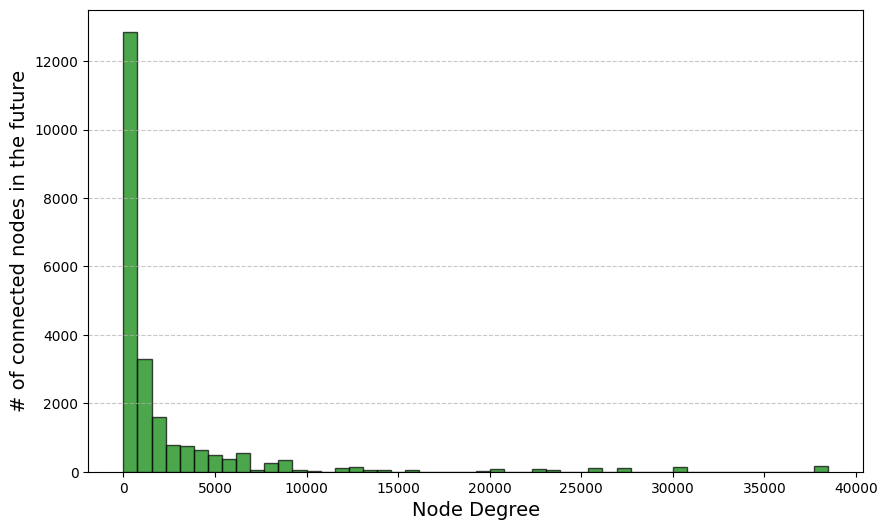

In [10]:
from matplotlib import pyplot as plt

connected_degrees = degree_vector[connected_later.flatten()]
bins = np.linspace(0, degree_vector.max(), 51)

bar_heights_connected, bar_thresholds_connected = np.histogram(connected_degrees, bins=bins)
bin_centers = (bar_thresholds_connected[:-1] + bar_thresholds_connected[1:]) / 2

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, bar_heights_connected, width=np.diff(bar_thresholds_connected), alpha=0.7, color='green', edgecolor='black')
plt.xlabel("Node Degree", fontsize=14)
plt.ylabel("# of connected nodes in the future", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# oh well that's unfortunate. What do we do next?

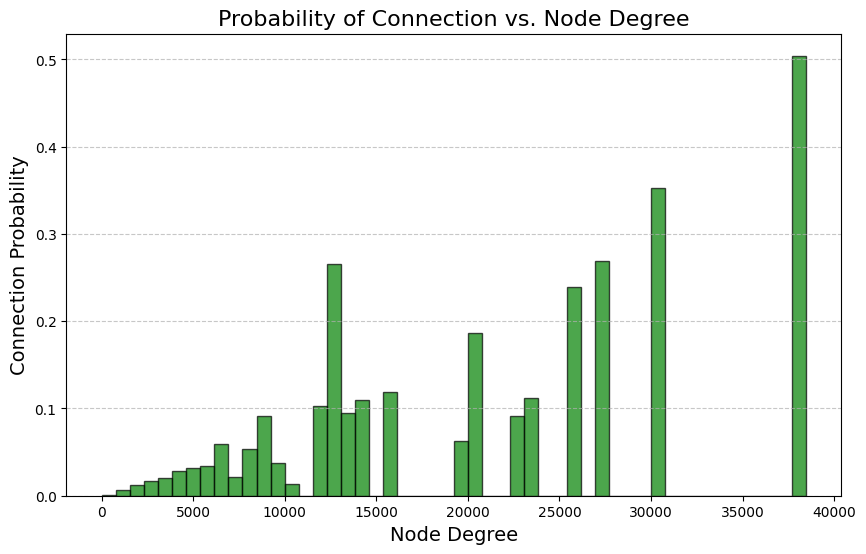

In [11]:
all_degrees = degree_vector[unconnected_vertex_pairs.flatten()]

bar_heights_all, bar_thresholds_all = np.histogram(all_degrees, bins=bins)

# Calculate connection probabilities (we are using the same bin edges)
connection_probabilities = np.divide(
    bar_heights_connected, bar_heights_all,
    out=np.zeros_like(bar_heights_connected, dtype=np.float64),
    where=bar_heights_all > 0
)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, connection_probabilities, width=np.diff(bar_thresholds_connected), alpha=0.7, color='green', edgecolor='black')
plt.xlabel("Node Degree", fontsize=14)
plt.ylabel("Connection Probability", fontsize=14)
plt.title("Probability of Connection vs. Node Degree", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


It seems that with node degree growing the probability of it getting connected in the future increases; preferential attachment hypothesis holds. The example below was not implemented by me but was rather taken directly from M4A for illustrative purposes:

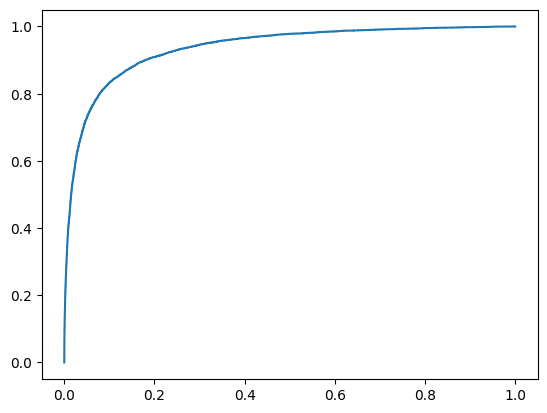

AUC (node degree + node degree): 0.9361842725416991


In [12]:
from utils import calculate_ROC

pred_degree_0 = degree_vector[unconnected_vertex_pairs[:,0]]
pred_degree_1 = degree_vector[unconnected_vertex_pairs[:,1]]

score_list_pa = pred_degree_0 + pred_degree_1

sorted_predictions_eval = np.argsort(-1.0*score_list_pa)

AUC = calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
print('AUC (node degree + node degree):', AUC)

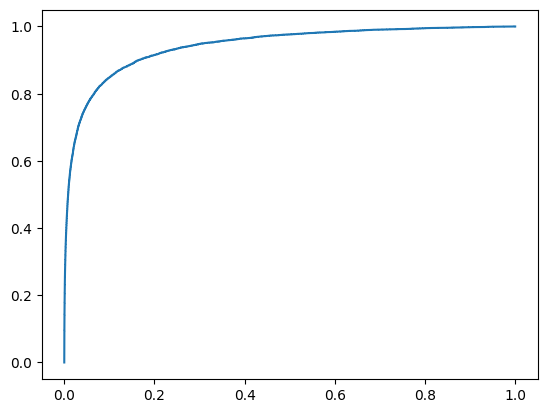

AUC (node degree * node degree): 0.9422142233955262


In [13]:
score_list_pa = pred_degree_0 * pred_degree_1

sorted_predictions_eval = np.argsort(-1.0*score_list_pa)

AUC = calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
print('AUC (node degree * node degree):', AUC)

## Clustering coefficient experiment
Node degree turned out to be a useful feature as the number of edges the node touches. What if the number of triangles touched is also indicative?

In [14]:
from tqdm import tqdm

cluster_coeffs_vector = np.zeros(NUM_OF_VERTICES)

for node in tqdm(range(NUM_OF_VERTICES), desc="Calculating clustering coefficients"):
    neighbors = adjM_csr[node].nonzero()[1]
    degree = len(neighbors)

    if degree < 2:
        cluster_coeffs_vector[node] = 0
    else:
        submatrix = adjM_csr[neighbors, :][:, neighbors]
        triangles = submatrix.nnz  # already multiplied by 2 (!!!) submatrix is symmetric
        cluster_coeffs_vector[node] = triangles / (degree * (degree - 1))

# cluster_coeffs_vector now contains the clustering coefficient for each node

Calculating clustering coefficients: 100%|██████████| 64719/64719 [00:32<00:00, 2012.83it/s]


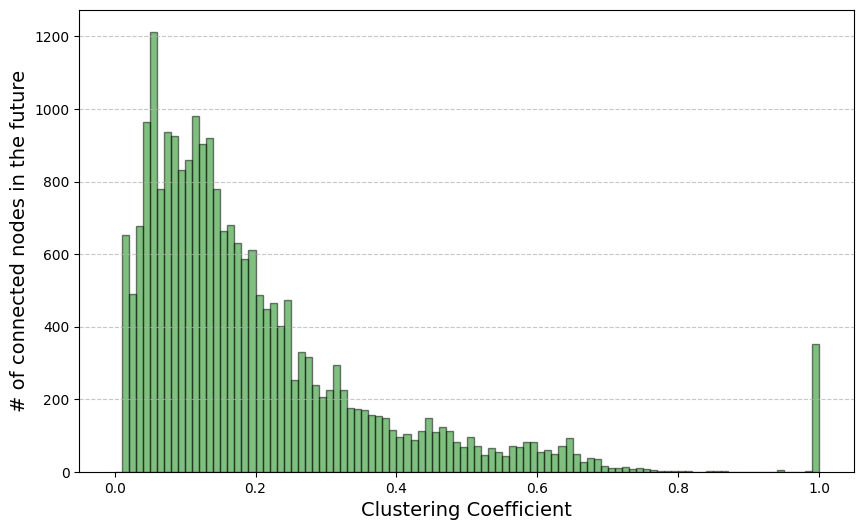

In [15]:
connected_ccs = cluster_coeffs_vector[connected_later.flatten()]
all_ccs = cluster_coeffs_vector[unconnected_vertex_pairs.flatten()]
bins = np.linspace(0, cluster_coeffs_vector.max(), 101)

bar_heights_connected, bar_thresholds_connected = np.histogram(connected_ccs, bins=bins)
bar_heights_all, bar_thresholds_all = np.histogram(all_ccs, bins=bins)
bin_centers = (bar_thresholds_connected[:-1] + bar_thresholds_connected[1:]) / 2

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, bar_heights_connected, width=np.diff(bar_thresholds_connected), alpha=0.5, color='green', edgecolor='black', label="Connected")
plt.xlabel("Clustering Coefficient", fontsize=14)
plt.ylabel("# of connected nodes in the future", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

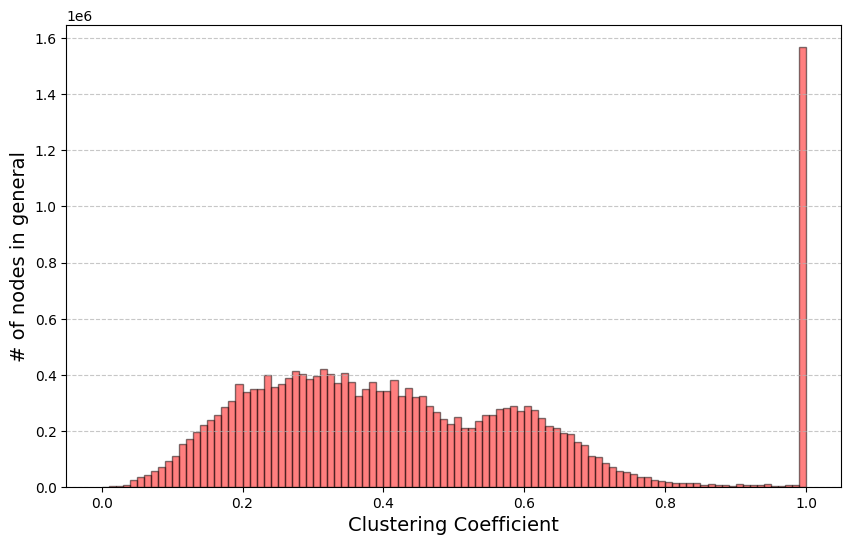

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, bar_heights_all, width=np.diff(bar_thresholds_connected), alpha=0.5, color='red', edgecolor='black', label="All")
plt.xlabel("Clustering Coefficient", fontsize=14)
plt.ylabel("# of nodes in general", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

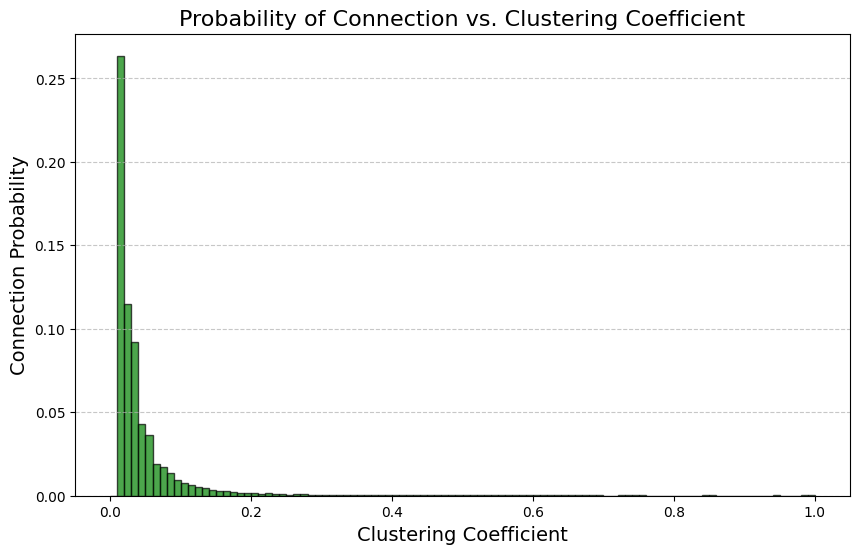

In [17]:
# Calculate connection probabilities (we are using the same bin edges)
connection_probabilities = np.divide(
    bar_heights_connected, bar_heights_all,
    out=np.zeros_like(bar_heights_connected, dtype=np.float64),
    where=bar_heights_all > 0
)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, connection_probabilities, width=np.diff(bar_thresholds_connected), alpha=0.7, color='green',
        edgecolor='black')
plt.xlabel("Clustering Coefficient", fontsize=14)
plt.ylabel("Connection Probability", fontsize=14)
plt.title("Probability of Connection vs. Clustering Coefficient", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can see that the lower clustering coefficient is, the higher the probability of the nodes getting connected.
Will it perform well on the original prediction task? For this purposes M4's framework is useful but has to be modified to serve us well.

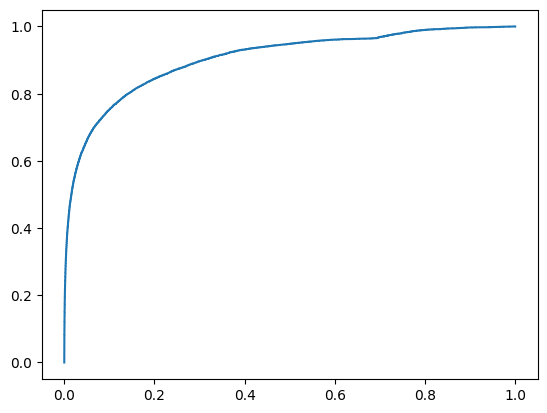

AUC (CC + CC): 0.9043308542630907


In [18]:
from utils import calculate_ROC

pred_degree_0 = cluster_coeffs_vector[unconnected_vertex_pairs[:,0]]
pred_degree_1 = cluster_coeffs_vector[unconnected_vertex_pairs[:,1]]

score_list_cc = pred_degree_0 + pred_degree_1

sorted_predictions_eval = np.argsort(score_list_cc)

AUC = calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
print('AUC (CC + CC):', AUC)

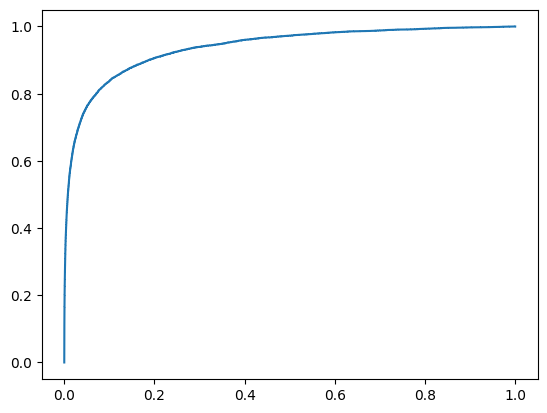

AUC (CC * CC): 0.9379542722142813


In [19]:
score_list_cc = pred_degree_0 * pred_degree_1

sorted_predictions_eval = np.argsort(score_list_cc)

AUC = calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
print('AUC (CC * CC):', AUC)

## Ruzicka similarity experiment
Common neighbours index implemented in M4B proved successful under certain settings. We know its normalized variant as Jaccard Index that operates over binary vectors (in graph context that means at most 1 unweighted link between any 2 nodes). To suit the fact that our edges might be not binary sometimes, we will try using Ruzicka similarity as weighted variant of Jaccard Index.

In [20]:
from utils import calculate_ROC

n = 10**6
i = 0
score_list_ruzicka = np.zeros((n,))
for pair in tqdm(unconnected_vertex_pairs[:n], desc="Computing Ruzicka scores"):
    minimum_vector = adjM_csr[pair[0],:].minimum(adjM_csr[pair[1],:])
    maximum_vector = adjM_csr[pair[0],:].maximum(adjM_csr[pair[1],:])

    numerator = minimum_vector.sum()
    denominator = maximum_vector.sum()

    if denominator == 0:
        score_list_ruzicka[i] = 0
    else:
        score_list_ruzicka[i] = numerator / denominator

Computing Ruzicka scores: 100%|██████████| 1000000/1000000 [16:38<00:00, 1001.40it/s]


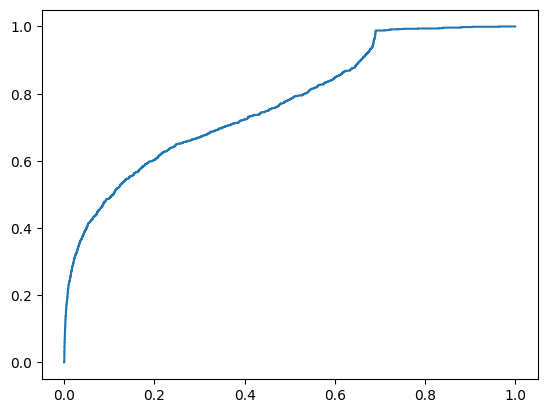

AUC (Ruzicka similarity, 1/10 of the test set): 0.7720950944896596


In [21]:
sorted_predictions_eval = np.argsort(-1.0 * score_list_ruzicka)

AUC = calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
print('AUC (Ruzicka similarity, 1/10 of the test set):', AUC)

Why does it perform much worse? Can we optimize already computed scores if we see the distributions?

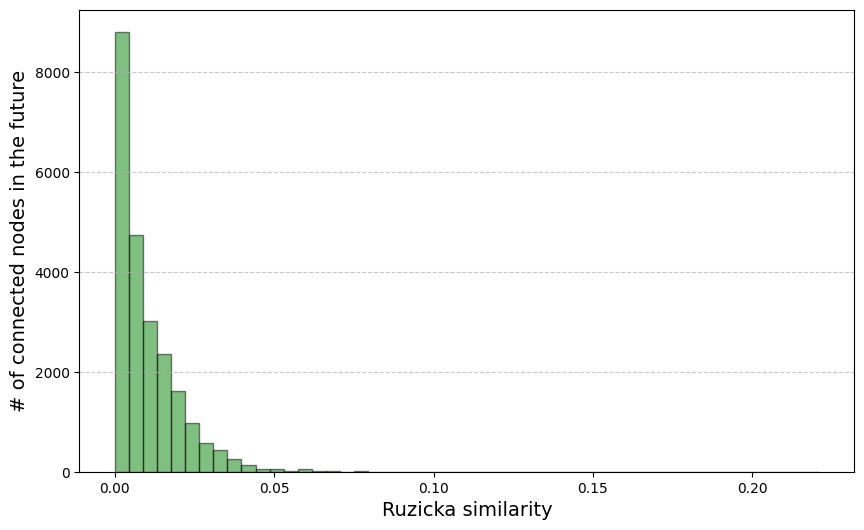

In [22]:
connected_ruzickas = score_list_ruzicka[connected_later.flatten()]
all_ruzickas = score_list_ruzicka[unconnected_vertex_pairs.flatten()]
bins = np.linspace(0, score_list_ruzicka.max(), 51)

bar_heights_connected, bar_thresholds_connected = np.histogram(connected_ruzickas, bins=bins)
bar_heights_all, bar_thresholds_all = np.histogram(all_ruzickas, bins=bins)
bin_centers = (bar_thresholds_connected[:-1] + bar_thresholds_connected[1:]) / 2

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, bar_heights_connected, width=np.diff(bar_thresholds_connected), alpha=0.5, color='green', edgecolor='black', label="Connected")
plt.xlabel("Ruzicka similarity", fontsize=14)
plt.ylabel("# of connected nodes in the future", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

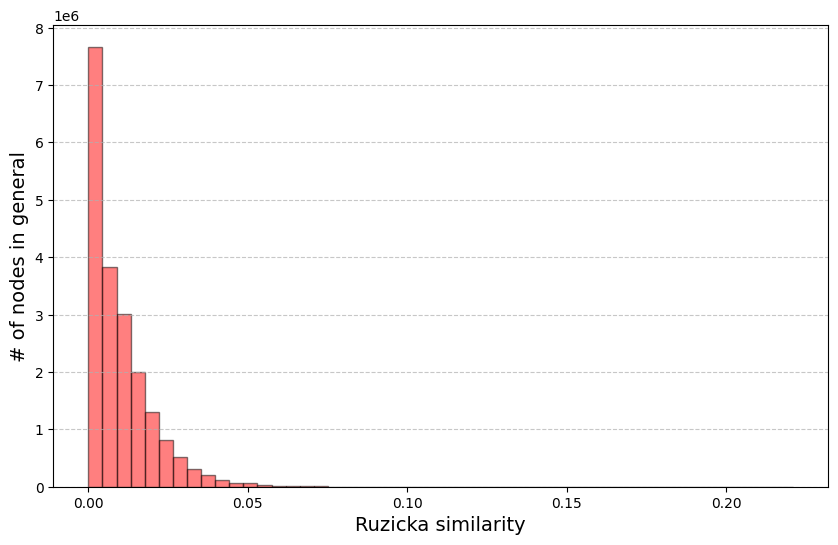

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, bar_heights_all, width=np.diff(bar_thresholds_connected), alpha=0.5, color='red', edgecolor='black', label="All")
plt.xlabel("Ruzicka similarity", fontsize=14)
plt.ylabel("# of nodes in general", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

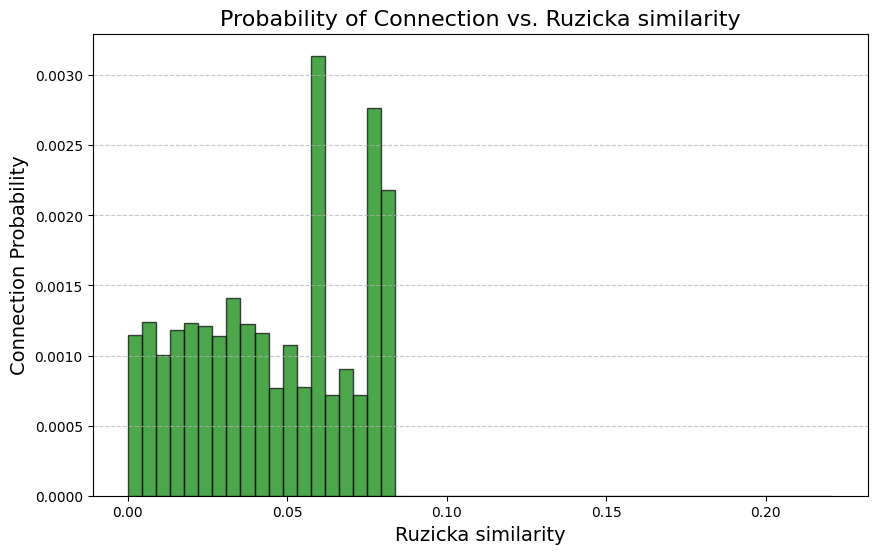

In [24]:
# Calculate connection probabilities (we are using the same bin edges)
connection_probabilities = np.divide(
    bar_heights_connected, bar_heights_all,
    out=np.zeros_like(bar_heights_connected, dtype=np.float64),
    where=bar_heights_all > 0
)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, connection_probabilities, width=np.diff(bar_thresholds_connected), alpha=0.7, color='green',
        edgecolor='black')
plt.xlabel("Ruzicka similarity", fontsize=14)
plt.ylabel("Connection Probability", fontsize=14)
plt.title("Probability of Connection vs. Ruzicka similarity", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Indeed, distributions reveal that Ruzicka score in its original formulation is not the strongest predictor on its own.

## Weighted Overlap index experiment
WOI is similar to Ruzicka score, however, the denominator is different, making it a measure of how a smaller neighborhood is subsumed by a bigger one.

In [26]:
from utils import calculate_ROC


n = 10**6
i = 0
score_list_overlap = np.zeros((n,))
for pair in tqdm(unconnected_vertex_pairs[:n], desc="Computing weighted overlap scores"):
    minimum_vector = adjM_csr[pair[0],:].minimum(adjM_csr[pair[1],:])

    numerator = minimum_vector.sum()
    denominator = min(degree_vector[pair[0]], degree_vector[pair[1]])

    if denominator != 0:
        score_list_overlap[i] = numerator / denominator
    i += 1

Computing weighted overlap scores: 100%|██████████| 1000000/1000000 [13:07<00:00, 1269.83it/s]


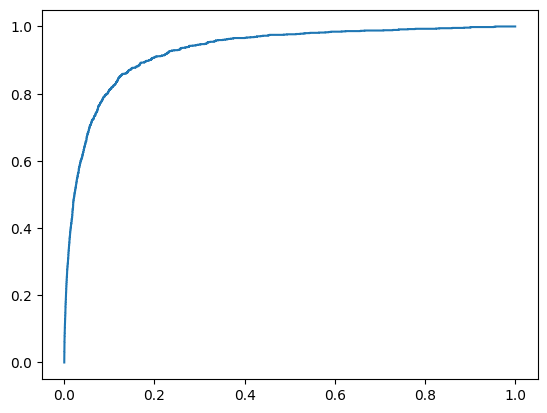

AUC (Weighted Overlap similarity, 1/10 of the test set): 0.9294888536615995


In [27]:
sorted_predictions_eval = np.argsort(-1.0 * score_list_overlap)

AUC = calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
print('AUC (Weighted Overlap similarity, 1/10 of the test set):', AUC)

## Adamic-Adar index experiment
Yet Another Local Neighborhood Overlap feature!!! Assumes the neighbours with lower degrees are more important, which is unusual if we remember how Node Degree experiment was successful.

In [45]:
from utils import calculate_ROC

n = 10**6
i = 0
score_list_aa = np.zeros((n,))
for u, v in tqdm(unconnected_vertex_pairs[:n], desc="Computing Adamic-Adar scores"):
    neighbours_u = set(adjM_csr[u, :].indices)
    neighbours_v = set(adjM_csr[v, :].indices)
    common_neighbors = np.array(list(neighbours_u & neighbours_v))

    if len(common_neighbors) > 0:
        valid_degrees = degree_vector[common_neighbors][degree_vector[common_neighbors] > 1]
        aa_score = np.sum(1 / np.log(valid_degrees)) if len(valid_degrees) > 0 else 0.0
    else:
        aa_score = 0.0
    score_list_aa[i] = aa_score
    i += 1

Computing Adamic-Adar scores: 100%|██████████| 1000000/1000000 [02:31<00:00, 6606.61it/s]


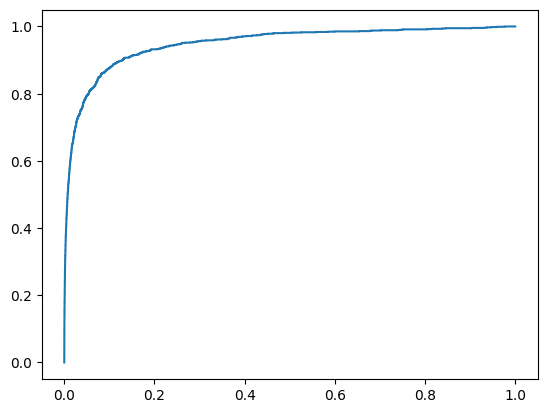

AUC (Adamic-Adar scores, 1/10 of the test set): 0.9489563111632955


In [46]:
sorted_predictions_eval = np.argsort(-1.0 * score_list_aa)

AUC = calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
print('AUC (Adamic-Adar scores, 1/10 of the test set):', AUC)